# Bases para hacer el modelaje de una capacitor

La situación física que se busca modelar es la siguiente:

<div>
<img src="capacitor.png" width="400"/>
</div>

Se tiene que hacer uso del método de Jacobi, el método de relajación de Jacobi modificado y el método de Gauss-Seidel. Esto, con el propósito de comparar la efectividad de cada uno de los métodos por medio de la cantidad de iteraciones requerida para llegar a cierto valor de convergencia.

## Método de relajación de Jacobi

El método de relajación de Jacobi es el método más sencillo que podemos aplicar para esta ecuación diferencial. 

Este método está basado en el método de relajación que estudiamos para encontrar las raíces de una ecuación no lineal. Basta con reacomodar la ecuación con la forma
$$
\phi'(x, y) = \frac{1}{4}\left[\phi(x+a, y) + \phi(x-a, y) + \phi(x, y+a) + \phi(x, y-a)\right],
$$
para poder aplicar el método de relajación. 
* Note que el problema tiene la misma forma que $x = f(x)$, con el cual se puede utilizar el método de relajación. 
* Básicamente, con esta metodología, obtenemos que el nuevo punto de la función en (x, y) es un promedio de la iteración anterior
* Lo único que se debe hacer, es 
  - Fijar $\phi(x, y)$ en los puntos de frontera
  - Considerar valores iniciales: estos valores pueden ser cualquier valor inicial que queramos escoger
  - Aplicar la ecuación anterior a **cada punto de la grilla**
  - Una vez finalizado este procedimiento, los valores obtenidos se vuelven a escoger para la siguiente iteración
  - Se termina cuando se alcanza la convergencia con cierta tolerancia deseada 
* A pesar de que el método de relajación no se puede utilizar para soluciones inestables, **se puede probar que el método de Jacobi siempre converge a una solución estable**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
# Esta función toma como argumentos el tamaño lineal de la grilla cuadrada,
# el valor del voltaje en la sección superior de la grilla y la tolerancia de convergencia 
def jacobi_relaxation(M, V1, V2, tolerance):
    # M es el multiplo del tamaño de la grilla, esto permite que se mantenga la relacion de 10x10 pero se pueda
    # Hacer una grilla con mayores divisiones generando mayor precision
    
    # Primero creamos los arreglos 2-dimensionales de la grilla
    # Vamos a necesitar dos según la regla de Jacobi
    # Note que usamos M+1, debido a que debemos contener la condición de frontera
    # phi contiene inicialmente los valores iniciales. Vamos a utilizar ceros.
    
    phi = np.zeros((M*10, M*10 + 1), dtype=float)
    # Ahora tenemos que colocar la condición inicial.
    # Recuerde accesos de listas en np.ndarray
    # Las condiciones de frontera de las placas con voltaje
    phi[2*M:8*M, 2*M] = V1
    phi[2*M:8*M, 8*M] = V2
    
    plt.imshow(phi)
    plt.grid
    plt.gray()
    plt.title("Estado inicial del sistema")
    plt.show()
    # phiprime se necesita para la iteración
    phiprime = np.zeros((M*10, M*10 + 1), dtype=float)
    # Iteración de Jacobi
    delta = 1.0
    its = 0
    while delta > tolerance:
        # Calculamos la iteración
        its += 1
        for i in range(1,M*10-1):
            for j in range(1,M*10):
                # Condición de frontera
                if  2*M <= i < 8*M and (j == 2*M  or j == 8*M) :
                    phi[2*M:8*M, 2*M] = V1
                    phi[2*M:8*M, 8*M] = V2 
                # Iteración principal
                else:
                    #COMPLETE AQUÍ
                    phiprime[i,j] = (0.25)*(phi[i+1,j] + phi[i-1,j] + phi[i,j+1] + phi[i,j-1])
        # Calculamos la diferencia máxima con respecto a los valores anteriores
        delta = np.max(np.abs(phi - phiprime))
        # Ahora intercambiamos los arreglos para la nueva iteración
        # El nuevo phi es el phiprime
        temp = phi
        phi = phiprime
        # El nuevo phiprime es el phi viejo
        phiprime = temp
    return phi, its

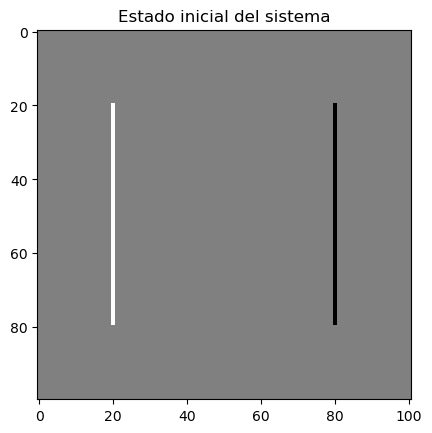

Las iteraciones requeridas fueron 4376


In [7]:
jacobi_vals, iterations = jacobi_relaxation(10, 1.0, -1.0, 1e-7)
print(f"Las iteraciones requeridas fueron {iterations}")

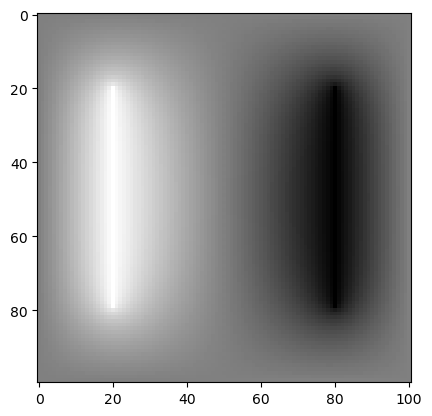

In [3]:
plt.imshow(jacobi_vals)
plt.gray()
plt.show()

### Método de Gauss-Seidel

Existe una optimización muy sencilla que se puede realizar al método de relajación de Jacobi.

En el caso del método de Jacobi, utilizamos los valores antiguos para calcular los valores nuevos. Sin embargo, podemos ir actualizando los valores en los **mismos espacios de memoria para cada iteración**. Asumiendo que los valores nuevos están más cercanos a la solución, esto implica que el número de iteraciones para coverger va a ser menor.

Basta con hacer una simple modificación al algoritmo:
$$
\phi(x, y) \leftarrow \frac{\phi(x+a, y) + \phi(x-a, y) + \phi(x, y+a) + \phi(x, y-a)}{4}.
$$
De esta manera, en cada iteración para cada punto de la grilla, se reescriben los valores modificados en el mismo lugar. Se puede probar que esta modificación mejora el número de iteraciones para converger a la solución.

* La diferencia crucial es que no utilizamos $\phi'(x, y)$ en el lado izquierdo de la ecuación iterativa, si no el mismo $\phi(x, y)$
* De esta forma, actualizamos el valor viejo de inmediato, no al final de la iteración total de la grilla
* El método puede ser combinado con el método modificado de Jacobi
* En general, sin embargo, el método modificado de Jacobi puede ser inestable numéricamente, mientras que el de Gauss-Seidel **es siempre estable**. 

El método de Gauss-Seidel modificado se escribe de manera equivalente al de Jacobi
$$
\phi(x, y) \leftarrow (1+\omega)\left[\frac{\phi(x+a, y) + \phi(x-a, y) + \phi(x, y+a) + \phi(x, y-a)}4\right] - \omega \phi (x,y),
$$
con la única diferencia que sustituimos $\phi(x, y)$, en lugar de asociarlo a $\phi'(x, y)$

In [4]:
def gauss_seidel_modified(M, V1, V2, omega, tolerance):
    # Primero creamos el arreglo 2-dimensionales de la grilla
    # Note que usamos M+1, debido a que debemos contener la condición de frontera
    # phi contiene inicialmente los valores iniciales. Vamos a utilizar ceros.
    phi = np.zeros((M*10, M*10 + 1), dtype=float)
    # Ahora tenemos que colocar la condición inicial.
    # Recuerde accesos de listas en np.ndarray
    phi[2*M:8*M, 2*M] = V1
    phi[2*M:8*M, 8*M] = V2
    # Vamos a guardar una copia para evaluar el error
    phi_copy = phi.copy()
    # Iteración de Gauss-Seidel
    delta = 1.0
    its = 0
    while delta > tolerance:
        # Calculamos la iteración
        its += 1
        for i in range(1,M*10-1):
            for j in range(1,M*10):
                # Condición de frontera
                if 2*M <= i < 8*M and (j == 2*M  or j == 8*M):
                    phi[2*M:8*M, 2*M] = V1
                    phi[2*M:8*M, 8*M] = V2
                # Iteración principal
                else:
                    # COMPLETE AQUÍ
                    phi[i,j] = ((1+omega)/4)*(phi[i+1,j] + phi[i-1,j] + phi[i,j+1] + phi[i,j-1]) - omega*phi[i,j]
        # Calculamos la diferencia máxima con respecto a los valores anteriores
        delta = np.max(np.abs(phi - phi_copy))
        # Copiamos los valores de la nueva iteración
        phi_copy = phi.copy()
        
    return phi, its

In [5]:
omega = np.linspace(0.1,0.9,9)
different_values = np.empty(omega.size,dtype=object)
for i in range(omega.size):
    #gauss_seidel_vals, iterations = gauss_seidel_modified(100, 1.0, 0.1, 1e-5)
    different_values[i] = gauss_seidel_modified(10, 1.0, -1, omega[i], 1e-5)

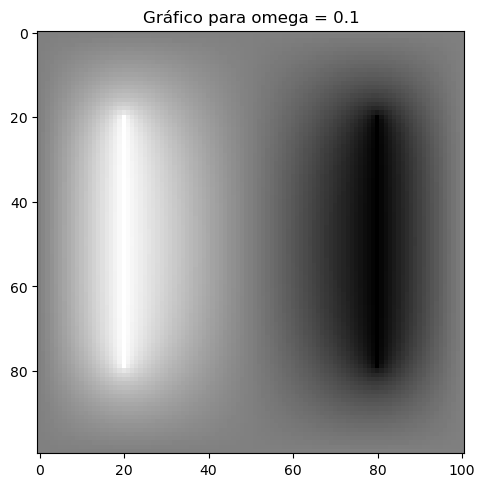

Las iteraciones requeridas fueron 1006


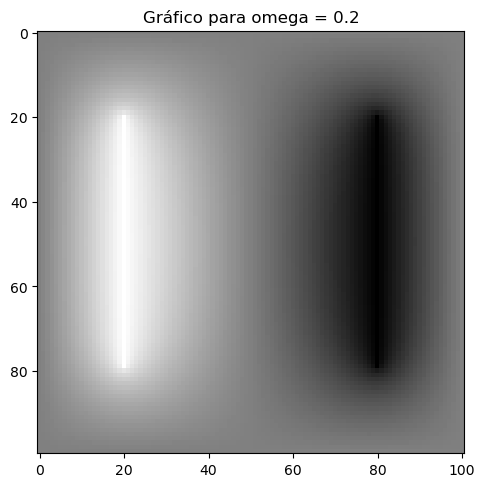

Las iteraciones requeridas fueron 916


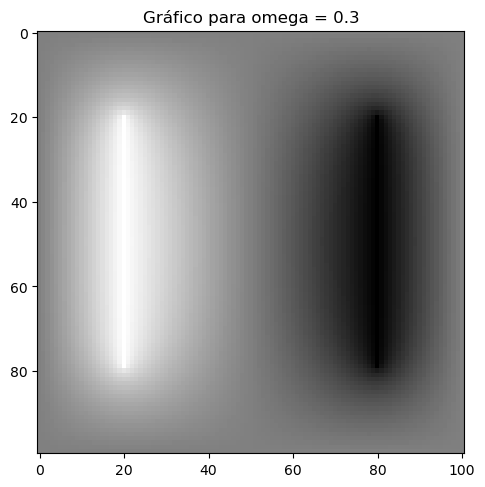

Las iteraciones requeridas fueron 850


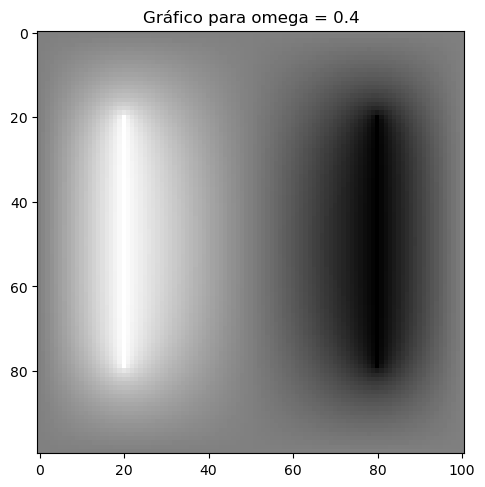

Las iteraciones requeridas fueron 782


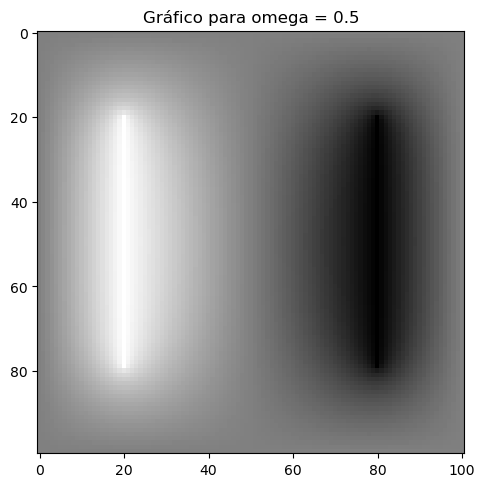

Las iteraciones requeridas fueron 699


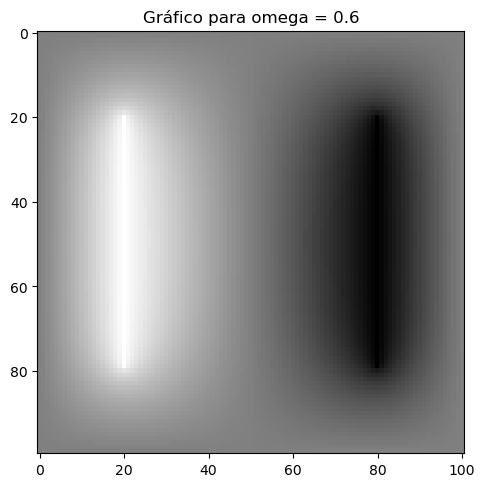

Las iteraciones requeridas fueron 602


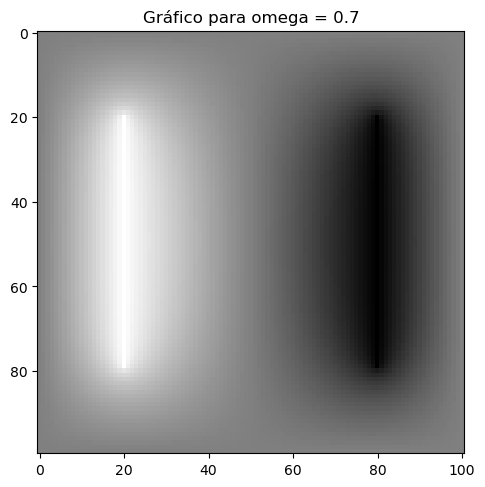

Las iteraciones requeridas fueron 491


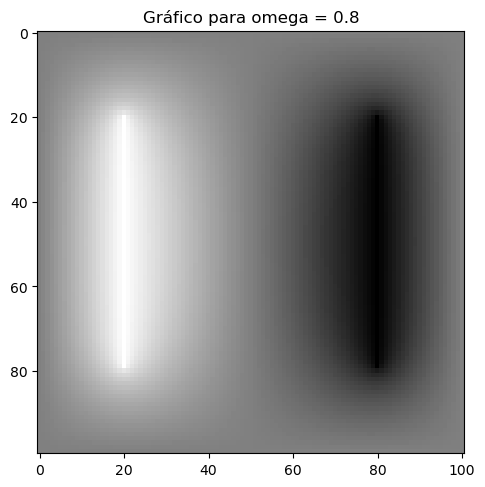

Las iteraciones requeridas fueron 363


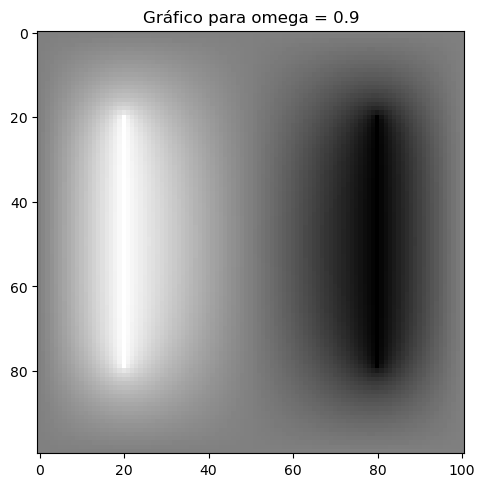

Las iteraciones requeridas fueron 199


In [6]:

for i in range(different_values.size):
    plt.imshow(different_values[i][0], cmap = "gray")
    plt.tight_layout()
    plt.title(f"Gráfico para omega = {omega[i]:.1f}")
    plt.show()
    print(f"Las iteraciones requeridas fueron {different_values[i][1]}")